In [1]:
%matplotlib inline
import pandas
import sklearn.cross_validation

In [2]:
sacramento = pandas.read_csv('CSV/Sacramentorealestatetransactions.csv',
                            index_col=0)
train_test_split = sklearn.cross_validation.train_test_split
(train_X, test_X, train_Y, test_Y) = train_test_split(sacramento,
                                                     sacramento.price,
                                                     test_size=0.1)
len(train_X), len(test_X)

(886, 99)

In [3]:
import sklearn.linear_model
ols = sklearn.linear_model.LinearRegression()
ols.fit(train_X[['beds', 'baths', 'sq__ft']], train_Y)
zip(['beds','baths', 'sq__ft'], ols.coef_), ols.intercept_

([('beds', -5069.0955484896131),
  ('baths', 61458.715342991207),
  ('sq__ft', 16.825378954294138)],
 117237.36687539495)

In [4]:
predictions = ols.predict(test_X[['beds', 'baths', 'sq__ft']])

TypeError: scatter() takes at least 2 arguments (0 given)

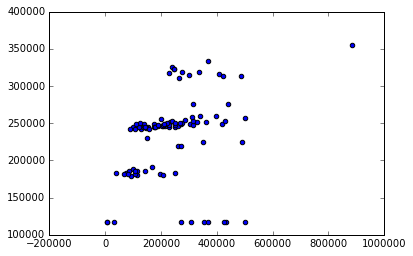

In [5]:
import matplotlib.pyplot
matplotlib.pyplot.scatter(test_Y, predictions)
matplotlib.pyplot.scatter()

In [6]:
from sklearn import metrics

In [7]:
metrics.r2_score(test_Y, predictions)

0.090781567456844514

# Comparison with other predictions

In [8]:
import sklearn.dummy
dummy = sklearn.dummy.DummyRegressor(strategy='mean')

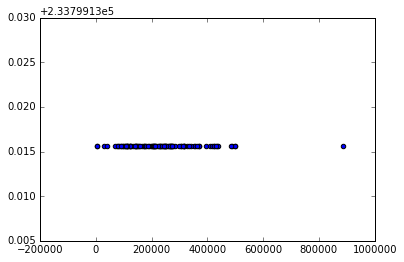

In [9]:
dummy.fit(train_X[['beds', 'baths', 'sq__ft']], train_Y)
dummy_predictions = dummy.predict(test_X[['beds', 'baths', 'sq__ft']])
matplotlib.pyplot.scatter(test_Y, dummy_predictions)

In [10]:
sklearn.metrics.r2_score(test_Y, dummy_predictions)

-0.00066360189218195309

In [11]:
import sklearn.tree
tree = sklearn.tree.DecisionTreeRegressor()

-0.026001336211914694

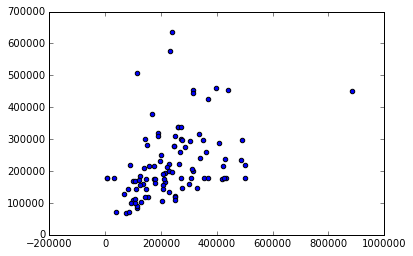

In [12]:
tree.fit(train_X[['beds', 'baths', 'sq__ft']], train_Y)
tree_predictions = tree.predict(test_X[['beds', 'baths', 'sq__ft']])
matplotlib.pyplot.scatter(test_Y, tree_predictions)
sklearn.metrics.r2_score(test_Y, tree_predictions)

Lets's re-do some of yesterday's pre-processing and see how we go.

In [13]:
sacramento['zip_region'] = sacramento.zip / 10
sacramento['is_condo'] = sacramento.type == 'Condo'
sacramento['is_residential'] = sacramento.type == 'Residential'
columns = ['beds', 'baths', 'sq__ft', 'zip', 'zip_region',
          'is_condo', 'is_residential', 'latitude', 'longitude']

In [14]:
train_test_split = sklearn.cross_validation.train_test_split
(train_X, test_X, train_Y, test_Y) = train_test_split(sacramento,
                                                     sacramento.price,
                                                     test_size=0.1)

0.38230043602825892

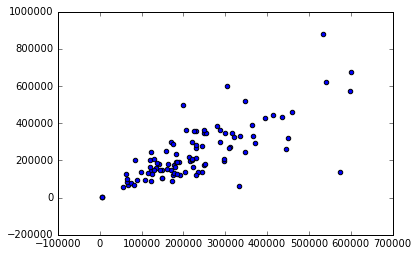

In [15]:
tree.fit(train_X[columns], train_Y)
tree_predictions = tree.predict(test_X[columns])
matplotlib.pyplot.scatter(test_Y, tree_predictions)
sklearn.metrics.r2_score(test_Y, tree_predictions)

In [16]:
sklearn.metrics.median_absolute_error(test_Y, tree_predictions)

44750.0

In [17]:
sklearn.metrics.mean_absolute_error(test_Y, tree_predictions)

65552.383838383845

# Doing this analysis for real

In [18]:
import sklearn.grid_search

In [21]:
params = {
    'max_depth': range(1,10),
    'max_features': [None, 1, 2, 4]
}
tree = sklearn.tree.DecisionTreeRegressor()
searcher = sklearn.grid_search.GridSearchCV(tree, params, cv=10)
searcher.fit(sacramento[columns], sacramento.price)
searcher.best_score_

-0.65496492768325976

In [22]:
searcher.best_params_

{'max_depth': 5, 'max_features': 4}

In [23]:
searcher.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=4,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [24]:
FinalAnswerBestPredictor = sklearn.tree.DecisionTreeRegressor(max_depth=6, max_features=4)
FinalAnswerBestPredictor.fit(sacramento[columns], sacramento.price)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=4,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [25]:
FinalAnswerBestPredictor.score(sacramento[columns], sacramento.price)

0.7194766720316722

In [38]:
params = {
    'residual_threshold': range(100000,200000,5000),
    'max_trials': [100, 500, 1000]
}
ransac = sklearn.linear_model.RANSACRegressor()
searcher = sklearn.grid_search.GridSearchCV(ransac, params, cv=10)
searcher.fit(sacramento[columns], sacramento.price)
searcher.best_score_

-3.2897775354908916

In [39]:
searcher.best_params_

{'max_trials': 100, 'residual_threshold': 160000}

In [41]:
#searcher.best_estimator_.predict()
two_samples = sacramento.sample(2)
predictions = searcher.best_estimator_.predict(two_samples[columns])
zip(two_samples.price, predictions)

[(157500, 196950.96304735541), (114750, 108362.47043461725)]

In [49]:
params = {
    'alpha': [0.1, 10.0, 100.0, 1000000, 10000000]
}
lasso = sklearn.linear_model.Lasso()
searcher = sklearn.grid_search.GridSearchCV(lasso, params, cv=10)
searcher.fit(sacramento[columns], sacramento.price)
searcher.best_score_

-0.87312425703695029

In [50]:
searcher.best_params_

{'alpha': 1000000}

In [51]:
zip(columns, searcher.best_estimator_.coef_)

[('beds', 0.0),
 ('baths', 0.0),
 ('sq__ft', 53.872609343089692),
 ('zip', -83.870601288039666),
 ('zip_region', -0.0),
 ('is_condo', -0.0),
 ('is_residential', 0.0),
 ('latitude', 0.0),
 ('longitude', 0.0)]